## Parking Violations in NYC -  Exploratory Analysis with visualizations

The Department of Finance in New York City is responsible for collecting and processing payments for all parking tickets. Department collects data on every parking ticket issued in NYC (~10M per year!). Data used for this analysis is taken from NYC open data website.I used the data of one fiscal year from **July 2020 to June 2021**. 


### Inspiration:

1. Where are tickets most commonly issued?
- Bottom 10 precincts with least number of parking violations
- Top 10 precincts with maximum number of parking violations
2. What is the precinct wise parking violation pattern?
3. what is the violation count across boroughs over the year?
4. When are tickets most likely to be issued? Any seasonality (weekly/monthly)?
5. What are most frequently occuring parking violation types?
6. The parked vehicles are registered in different states, does the registered states include only neighbouring states?
7. The data included the manufacturing year of vehicle which made the parking violation, how the violations are distributed among them?
8. Major inspiration is to look for the repeat offenders, how many unique plate-ids are repeatedly violating the parking rules?


In [1]:
#importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import datetime as dt
from keplergl import KeplerGl
import json

In [2]:
#loading the parking tickets violation data
parking_vio_df = pd.read_csv("Parking_Violations_Issued_-_Fiscal_Year_2021.csv")

/Users/sonamsonam/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#cleaning the data and formatting it to visualize later
#created a dictionary of months to map with numbers
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar',4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sept',10: 'Oct', 11: 'Nov', 12: 'Dec'}
parking_vio_df['Issue Date'] = pd.to_datetime(parking_vio_df['Issue Date'],format = "%m/%d/%Y")
#using the data for July 2020 to Jun 2021 data - one fiscal year
parking_vio_df = parking_vio_df[(parking_vio_df['Issue Date']>='2020-07-01')&(parking_vio_df['Issue Date']<'2021-07-01')]
parking_vio_df['Month']=parking_vio_df['Issue Date'].dt.month.map(month_dict)
parking_vio_df = parking_vio_df[(~parking_vio_df['Plate ID'].isna())&(~parking_vio_df['Violation Time'].isna())]

In [4]:
#Loading the new data- geojson file to visualize in geopandas across the precincts 
precinct_df = gpd.read_file('Precincts.geojson')
precinct_df['precinct'] = precinct_df['precinct'].astype(int)
precinct_df = precinct_df.rename(columns={'precinct':'Violation Precinct'})
parking_vio_df = pd.merge(parking_vio_df, precinct_df[['Violation Precinct','geometry']], how='inner', on='Violation Precinct')
parking_vio_df['Summons Number'] = parking_vio_df['Summons Number'].astype(str)

In [5]:
# An excel file to map the precincts across boroughs 
# For broad visualization across NYC boroughs
boro_info_df = pd.read_excel("boro_wise.xlsx")
boro_info_df = boro_info_df.rename(columns={'Pct':'Violation Precinct'})
parking_vio_df = pd.merge(parking_vio_df, boro_info_df[['Violation Precinct','BoCode','BoroughNm']], how='inner', on='Violation Precinct')
parking_vio_df['Violation Precinct'] = parking_vio_df['Violation Precinct'].astype(str)

In [6]:
# groupby to calculate the top 10 and bottom 10 precincts with parking violations- min and max
precinct_wise_df = parking_vio_df['Summons Number'].groupby(by=parking_vio_df['Violation Precinct']).count().sort_values(ascending=False).reset_index()
top_10 = precinct_wise_df.head(10)
bottom_10 = precinct_wise_df.tail(10)

Text(0.5, 0, 'Precinct Number')

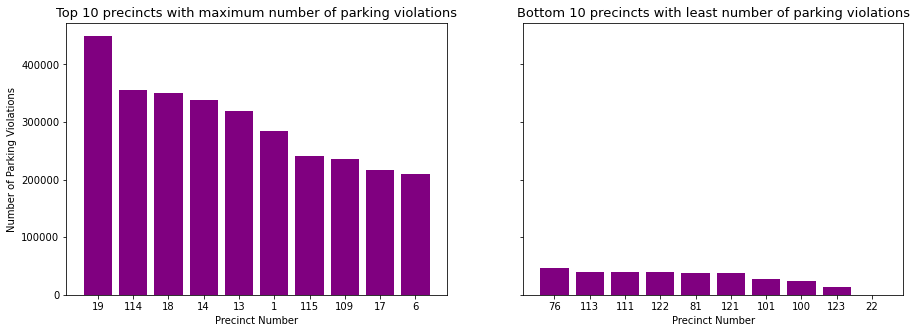

In [27]:
#using the subplots to visualize the top and bottom both parallely.
#sharey is used to have a common Y axis to compare the value in two subplots
fig, axs = plt.subplots(1, 2, figsize=(15,5),sharey=True)
# creating the bar plot
x1 = top_10['Violation Precinct']
y1 = top_10['Summons Number']
x2 = bottom_10['Violation Precinct']
y2 = bottom_10['Summons Number']
axs[0].bar(x1, y1, color ='purple', width = 0.8) 
axs[0].set_title("Top 10 precincts with maximum number of parking violations", fontsize=13)
axs[1].bar(x2, y2, color ='purple', width = 0.8) 
axs[1].set_title("Bottom 10 precincts with least number of parking violations", fontsize=13)
axs[0].set_ylabel('Number of Parking Violations')
axs[0].set_xlabel('Precinct Number')
axs[1].set_xlabel('Precinct Number')

### Solution to Questions:

1. Where are tickets most commonly issued?
**Answer**:
Data is broadly available corresponding to New York City 5 boroughs and further divided into the police precincts. Police precincts are small geographical areas to handle the crimes and violations in the city in planned way. In above graph we have visualized the: 
- Bottom 10 precincts with least number of parking violations
- Top 10 precincts with maximum number of parking violations

2. What is the precinct wise parking violation pattern?
**Answer**:
From above data we can clearly see that the parking violations can occur between a wide range based on the area type and population size. Range here varies from - [449291 to 489]

In [8]:
#to visualize the data boroughwise- how many violations are made across 5 different NYC Boroughs
boro_wise_df = parking_vio_df['Summons Number'].groupby(by=parking_vio_df['BoroughNm']).count().reset_index()

In [9]:
monthly_df = parking_vio_df[['Issue Date', 'Month', 'Summons Number','BoroughNm']]
monthly_df['date'] = pd.to_datetime(monthly_df['Issue Date'].apply(lambda x: str(x.year) + "-" + str(x.month)), format="%Y-%m")
monthly_df = monthly_df.groupby(['BoroughNm','date'])['Summons Number'].count().reset_index()

<ipython-input-9-dea151f24bfe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_df['date'] = pd.to_datetime(monthly_df['Issue Date'].apply(lambda x: str(x.year) + "-" + str(x.month)), format="%Y-%m")


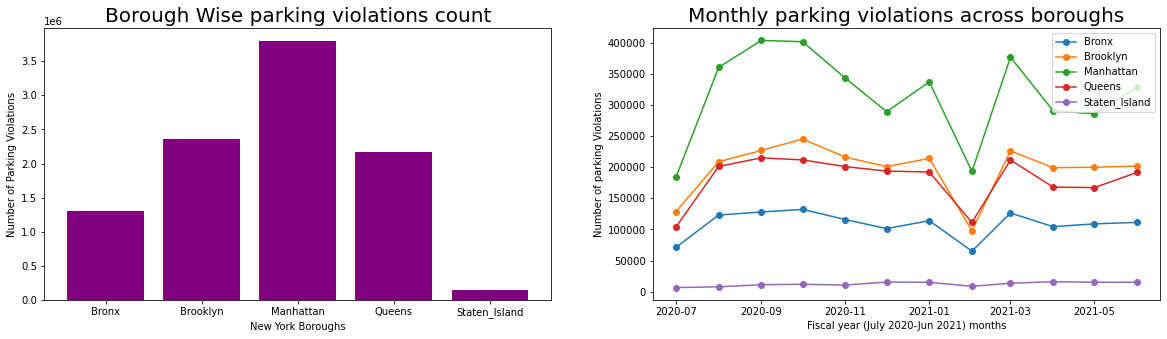

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
x = boro_wise_df['BoroughNm']
y = boro_wise_df['Summons Number']
axs[0].bar(x, y, color ='purple', width = 0.8) 
axs[0].set_title("Borough Wise parking violations count", fontsize=20)
axs[0].set_ylabel('Number of Parking Violations')
axs[0].set_xlabel('New York Boroughs')
plt.ylabel("Number of parking Violations")
plt.xlabel("Fiscal year (July 2020-Jun 2021) months")
for boro in monthly_df.BoroughNm.unique():
    x = monthly_df[monthly_df.BoroughNm==boro]['date']
    y = monthly_df[monthly_df.BoroughNm==boro]['Summons Number']
    axs[1].plot(x, y,marker='o', label=boro)
axs[1].set_title("Monthly parking violations across boroughs", fontsize=20)
axs[1].legend()
plt.show()

### Solution to Questions:

3. What is the violation count across boroughs over the year?
**Answer:**
The above graph shows that maximum violations are caused in Manhattan followed by Brooklyn, in an year. As we know, manhattan is overly crowded and always has parking crunch, above graph justifies that.

In Above line graph, we can see the patterns of parking violations over the time series of 12 months. Each color representing a borough and all the lines are going in parallel showing similar pattern of rise and drop in violations over the months. Manhattan is above at all times in number of parking violations. Also interesting to see that there is a sudden drop in parking violations in Feb 2021, which could be attributed to lower traffic on streets because of COVID-19 surge + winter weather.


<ipython-input-11-86c30257df83>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_df['dow'] = weekly_df['Issue Date'].dt.dayofweek


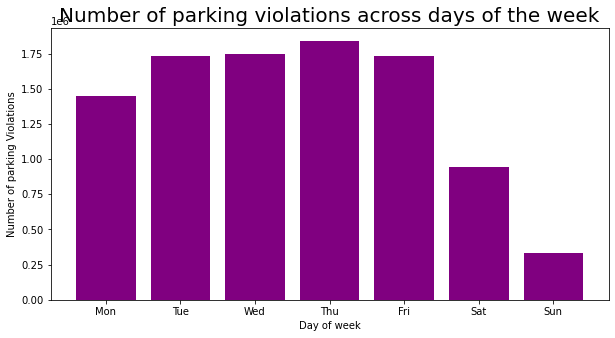

In [11]:
#weekly data analysis - how the violations pattern change across the day of week
week_dict = {0: 'Mon', 1: 'Tue', 2: 'Wed',3: 'Thu', 4: 'Fri', 5: 'Sat',6: 'Sun'}
weekly_df = parking_vio_df[['Issue Date', 'Summons Number','BoroughNm']]
weekly_df['dow'] = weekly_df['Issue Date'].dt.dayofweek
weekly_df = weekly_df.groupby(['dow'])['Summons Number'].count().reset_index()
weekly_df['dow'] = weekly_df['dow'].map(week_dict)

fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot
x = weekly_df['dow']
y = weekly_df['Summons Number']
plt.bar(x, y, color ='purple', width = 0.8) 
plt.xlabel("Day of week")
plt.ylabel("Number of parking Violations")
plt.title("Number of parking violations across days of the week", fontsize=20)
plt.show()

### Solution to Questions:

4. When are tickets most likely to be issued? Any seasonality (weekly/monthly)?

**Answer:**
Above graph shows that "Thursday" has overall highest parking violations and "Sunday" has the least count. As we all know - maximum parking signs in NYC are with Sunday Exception which means maximum slots are available for all day parking on sundays which leads to lowest parking violations. This graph shows the weekly pattern over the fiscal year 2021. Additionally, a lot of businesses are closed on Sundays leading to less parking requirements.


In [12]:
#Which type of violations are occuring max. in number
top_vio_map = {'21': 'Street Clean','38': 'No windshield receipt/tag ','14': 'No Standing','20': 'No Parking','40': '15ft of fire hydrant','71': 'No NY inspection sticker','46': 'Double parking','70': 'No NY registration sticker','37': 'Time exceeded','19': 'Bus Stop'}
violations_df = parking_vio_df['Summons Number'].groupby(by=parking_vio_df['Violation Code']).count().sort_values(ascending=False).reset_index()
violations_df['Violation Code'] = violations_df['Violation Code'].astype(str)
violations_df['Violation Code'] = violations_df['Violation Code'].map(top_vio_map)

In [13]:
top_vio = violations_df.head(10)

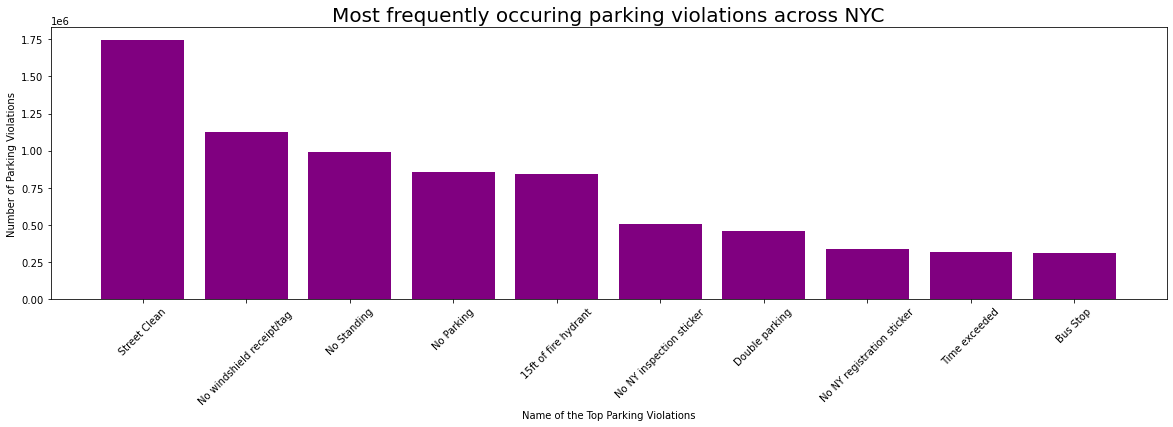

In [25]:
fig = plt.figure(figsize = (20, 5)) 
# creating the bar plot
x = top_vio['Violation Code']
y = top_vio['Summons Number']
plt.bar(x, y, color ='purple', width = 0.8)
plt.xlabel("Name of the Top Parking Violations")
plt.ylabel("Number of Parking Violations")
plt.xticks(rotation=45)
plt.title("Most frequently occuring parking violations across NYC", fontsize=20)
plt.show()

### Solution to Questions:

5. What are most frequently occuring parking violation types?

**Answer:** "Street Clean" - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device. It is the main cause of parking violation in NYC. Next main cause is No windshield tag and followed by others. As street clean is designated from time to time with no permanent schedule, so unawareness can be the main reason for this or due to street clean notice the whole street is unavailable for parking which might lead to parking crunch at near by sites and it leads to more violations. 

In [15]:
#Vehicles are registered in different states - to analyse the count of vehicles from neighbouring states
reg_state_df = parking_vio_df.groupby(['Registration State'])['Summons Number'].count().sort_values(ascending = False).reset_index()
reg_state_df = reg_state_df.head(10)

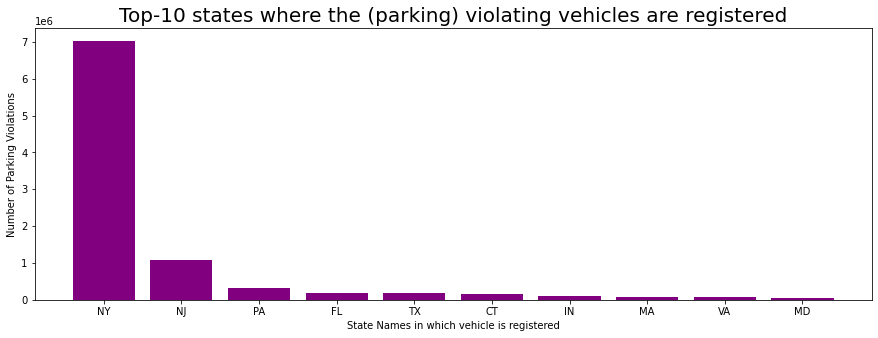

In [16]:
fig = plt.figure(figsize = (15, 5)) 
# creating the bar plot
x = reg_state_df['Registration State']
y = reg_state_df['Summons Number']
plt.bar(x, y, color ='purple', width = 0.8)
plt.xlabel("State Names in which vehicle is registered")
plt.ylabel("Number of Parking Violations")
plt.title("Top-10 states where the (parking) violating vehicles are registered", fontsize=20)
plt.show()

### Solution to Questions:

6. The parked vehicles are registered in different states, does the registered states include only neighbouring states?
**Answer:**
Maximum parking violation vehicles are from New york, followed by New Jersey. Neighbouring states can also have a big contribution to this due to proximity and people commuting to&fro for work. From this above graph, we can clearly see that Florida and Texas are not even near by states but the vehicles are registered to those states. This fact was quite intriguing. 

In [17]:
# manufacturing year of the vehicle - to analyse the trend in the city for old and new vehicles
vehicle_year_df = parking_vio_df.groupby(['Vehicle Year'])['Summons Number'].count().sort_values(ascending = False).reset_index()
vehicle_year_df = vehicle_year_df[(vehicle_year_df['Vehicle Year']>1990)& (vehicle_year_df['Vehicle Year']<2022)]

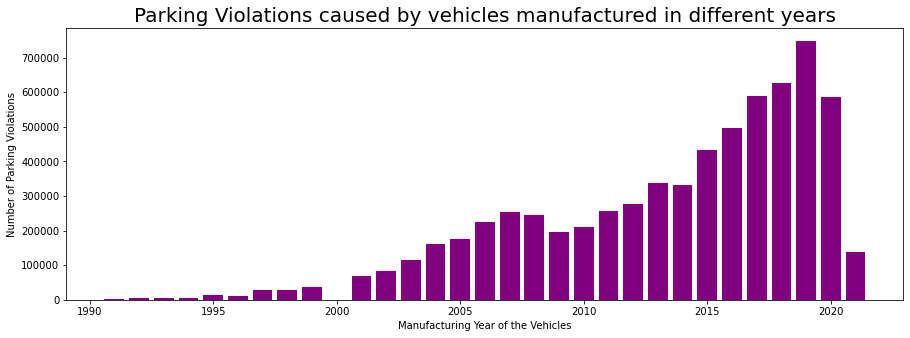

In [18]:
fig = plt.figure(figsize = (15, 5)) 
# creating the bar plot
x = vehicle_year_df['Vehicle Year']
y = vehicle_year_df['Summons Number']
plt.bar(x, y, color ='purple', width = 0.8)
plt.xlabel("Manufacturing Year of the Vehicles")
plt.ylabel("Number of Parking Violations")
plt.title("Parking Violations caused by vehicles manufactured in different years", fontsize=20)
plt.show()


### Solution to Questions:

7. The data included the manufacturing year of vehicle which made the parking violation, how the violations are distributed among them?
**Answer:**
For exploring more facts in the data, we plotted the distribution of manufacturing year of the vehicles that caused the parking violations. From above pattern we can clearly state that maximum vehicles are quite new (from past 5 years), but there is a significant population of cars from 2000-2010 as well. 

In [19]:
# Analyses for the Number plates for repeated violations
# frequent violations can raise certain questions - Unclaimed Vehicle/Old Vehicle etc
repeat_vio_df = parking_vio_df.groupby(['Plate ID', 'Violation Precinct'])['Summons Number'].count().sort_values(ascending = False).reset_index()
repeat_vio_df = repeat_vio_df[repeat_vio_df['Plate ID']!= 'BLANKPLATE']
repeat_vio_df = repeat_vio_df[repeat_vio_df['Summons Number'] > 1]
repeat_vio_df = repeat_vio_df.groupby(['Violation Precinct'])['Plate ID'].nunique().reset_index()
repeat_vio_df['Violation Precinct'] = repeat_vio_df['Violation Precinct'].astype(int)
repeat_vio_df = pd.merge(repeat_vio_df, precinct_df[['Violation Precinct','geometry']], how='inner', on='Violation Precinct')


In [20]:
repeat_vio_df = gpd.GeoDataFrame(repeat_vio_df)
repeat_vio_df = repeat_vio_df.rename(columns={'Violation Precinct':'Violation_Precinct','Plate ID':'PlateID'})

Text(0.5, 1.0, 'Unique count of repeat offenders by precinct')

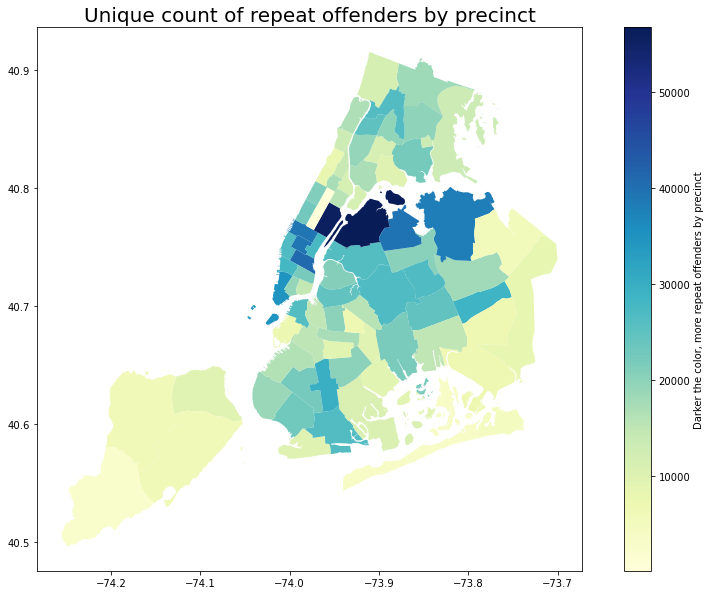

In [21]:
#precincts with maximum parking violations are in dark 
repeat_vio_df.plot(column='PlateID', cmap='YlGnBu', figsize=(15, 10), legend=True, legend_kwds={'label': "Darker the color, more repeat offenders by precinct"})

plt.title("Unique count of repeat offenders by precinct", fontsize=20)

### Solution to Questions:

8. Major inspiration is to look for the repeat offenders, how many unique plate-ids are repeatedly violating the parking rules?
**Answer:**
Above plot is drawn using the geopandas python library to visualize the heat map of Unique count of repeat offenders across each precinct. This gives us a glimpse that certain areas like staten island, long island, north of queens have low occurences of repeat offenders. As we know these areas are not very crowded and have enough parking spaces which leads to less violations and minimum repeat violations. On the other hand Manhattan and Brooklyn seems to have more repeat offenders due to parking crunch and other regulations.

In [22]:
violation_intensity_df = parking_vio_df.groupby(['Violation Precinct'])['Summons Number'].count().reset_index()
violation_intensity_df['Violation Precinct'] = violation_intensity_df['Violation Precinct'].astype(int)
violation_intensity_df = violation_intensity_df.rename(columns={'Violation Precinct':'Violation_Precinct','Summons Number':'total_parking_violations'})
violation_intensity_df = pd.merge(violation_intensity_df, repeat_vio_df[['Violation_Precinct','PlateID','geometry']], on='Violation_Precinct')
violation_intensity_df = violation_intensity_df.rename(columns={'PlateID':'Repeated violators count'})


In [23]:
with open('violation_intensity_map_config.json', 'r') as fp:
    map_config = json.load(fp)

violation_intensity_map = KeplerGl(height=500, config=map_config, data={'Parking violation intensity':gpd.GeoDataFrame(violation_intensity_df)})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [32]:
violation_intensity_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '1qk5km8', 'type': …

### Solution to Questions:
-Answer:
 The above visualization is made using "keplerGl" python library. Above map is interactive and with geographical boundaries. This 3-D graph tells us- 
 
 - Color shows the Intensity of Parking violations (Darker the color, more the violation intensity)
 - Height of the 3D graph tells us about Repeated violations by unique offenders.
 - Boundaries on the NYC map tells us the Precinct divisons
 
 Above method of visualization is apt for this situation as every aspect is contributing to a different detail of map. There are certain areas which are dark but have different heights means difference in repeat offenders in different areas.